In [120]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset,DataLoader

import os

import umap
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA

from src.models import VAE
from src.training import Trainer

import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from src.visualization import *

import plotly.graph_objects as go
import re
import string

In [2]:
data_path = '/stor/huakui/research/VB/ghx/joint-vae/datasets/Adult-heart/'
train = torch.load(os.path.join(data_path,'train_dataset.pt'))
val = torch.load(os.path.join(data_path,'val_dataset.pt'))
group_indexes = np.load(os.path.join(data_path,'disc_labels_mapping.npy'), allow_pickle = True).item()
group_indexes_reverse = dict()
for group in group_indexes:
    group_indexes_reverse[group] = {value:key for key,value in group_indexes[group].items()}
ln_file = open(os.path.join(data_path, 'label_names.txt'),'r')
label_names = ln_file.read().splitlines()
ln_file.close()

In [3]:
label_name_cont = [idx for idx,name in enumerate(label_names) if name not in group_indexes]
label_name_disc = [idx for idx,name in enumerate(label_names) if name in group_indexes]
# cont: 2 diffused latent, 2 kl latent, each label has a latent to supervise
# disc: 1 clustering latent, 1 kl latent, each label has a latent to supervise
diffuse_cont_dims = [0,1]
KL_cont_dims = [2,3,4,5,6,7]
unsupervised_cont_num = len(diffuse_cont_dims + KL_cont_dims)
cluster_disc_dims = [0,1]
KL_disc_dims = [1]
unsupervised_disc_num = len(cluster_disc_dims + KL_disc_dims)
n_cluster = 5
latent_spec = {'cont': len(label_name_cont) + unsupervised_cont_num, 
               'disc': unsupervised_disc_num*[n_cluster] + [len(i) for i in group_indexes.values()]}


cont_supervise_dict = {idx+len(diffuse_cont_dims)+len(KL_cont_dims):cont_dim for idx,cont_dim in enumerate(label_name_cont)}
disc_supervise_dict = {idx+len(cluster_disc_dims)+len(KL_disc_dims):disc_dim for idx,disc_dim in enumerate(label_name_disc)}
latent_name_cont = [str(i)+'_Diffuse' for i in diffuse_cont_dims] + \
                   [str(i)+'_KL_Cont' for i in KL_cont_dims] +\
                   [str(i)+'_'+label_names[cont_supervise_dict[i]] for i in cont_supervise_dict]
latent_name_disc = [str(i)+'_Cluster' for i in cluster_disc_dims] + \
                   [str(i)+'_KL_Disc' for i in KL_disc_dims] +\
                   [str(i)+'_'+label_names[disc_supervise_dict[i]] for i in disc_supervise_dict]

In [4]:
latent_spec

{'cont': 10, 'disc': [5, 5, 5, 2, 6, 12, 9, 25]}

In [5]:
for latent in disc_supervise_dict:
    print(latent, label_names[disc_supervise_dict[latent]])

3 AR1
4 AR2
5 AR3
6 cellType
7 subType


In [6]:
savePath = '/home/huakui/research/VB/ghx/joint-vae/results/Adult-heart'
if not os.path.exists(savePath):
    os.makedirs(savePath)
save_figs = False

In [7]:
#latent_spec = {'cont': 5,'disc': [4,4,5,6]}
model = VAE(latent_spec=latent_spec, 
            data_size = (len(train[0][0]),1), 
            use_cuda = torch.cuda.is_available())
# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# Define the capacities
# Continuous channels
cont_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,disc_capacity=disc_capacity,
                  clustering_lambda = 0.001, cluster_disc_dims = cluster_disc_dims,
                  diffusion_lambda=1, diffuse_cont_dims = diffuse_cont_dims, 
                  sigma = 5, random_walk_step = 1,
                  discrete_supervised_lambda = 100, disc_supervise_dict = disc_supervise_dict,
                  continuous_supervised_lambda = 10000, cont_supervise_dict = cont_supervise_dict,
                  cont_loss_type = 'mse', scaling_loss = False, 
                  print_loss_every=100, record_loss_every=5,
                  use_cuda = torch.cuda.is_available(), verbose = False)
train_loader = DataLoader(train, batch_size=128,shuffle=True)
# Train model 
trainer.train(train_loader, epochs = 400)

Epoch 400: 100%|██████████| 400/400 [14:52<00:00,  2.23s/it, Epoch_average_loss=13424.93]


In [8]:
latent_dist_list = {'cont':[], 'disc':[]}
for data in DataLoader(val,batch_size=1024,shuffle=False):
    x = data[0].view(data[0].size(0),-1).cuda()
    with torch.no_grad():
        latent_sample,latent_dist = model(x)
    latent_dist_list['cont'].append(latent_dist['cont'])
    latent_dist_list['disc'].append(latent_dist['disc'])

In [9]:
latent_dist_cont = [torch.cat([x[0] for x in latent_dist_list['cont']], dim=0),
                    torch.cat([x[1] for x in latent_dist_list['cont']], dim=0)]

latent_dist_disc = [torch.cat([x[i] for x in latent_dist_list['disc']], dim=0) for i in range(len(latent_spec['disc']))]
latent_dist = {'cont':latent_dist_cont, 'disc':latent_dist_disc}

In [155]:
for data in DataLoader(val,batch_size=len(train),shuffle=False):
    break

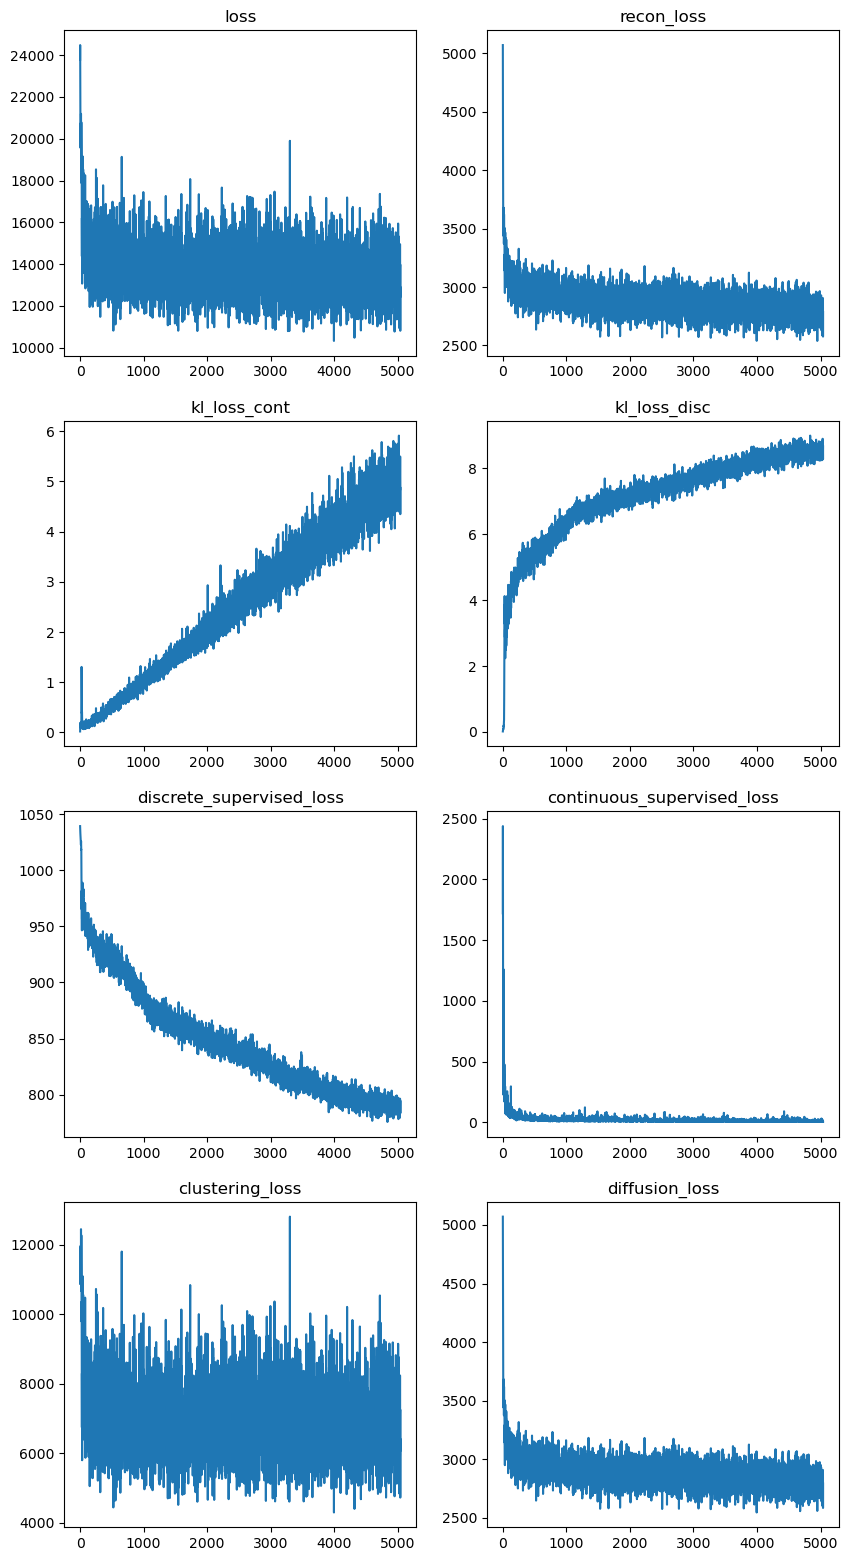

In [11]:
fig = draw_loss_curves(trainer.losses)
if save_figs:
    fig.savefig(os.path.join(savePath, 'img', 'fig1_lossCurves.png'))
fig.show()

In [12]:
# discrete labels
# each disc label dim is with its supervising latent
labels_disc = pd.DataFrame()
for latent in disc_supervise_dict:
    label_name = label_names[disc_supervise_dict[latent]]
    group_index = group_indexes_reverse[label_name]
    label_pos = [idx for idx,name in enumerate(label_names) if name==label_name][0]
    label = data[1][:,label_pos].int()
    labels_disc[label_name + ' (Label)'] = [group_index[int(i)] for i in label]
    label_hat = torch.argmax(latent_dist['disc'][latent].detach().cpu(),dim = 1)
    labels_disc[label_name + ' (Infer)'] = np.array(label_hat)
# disc latent that under clustering constrain (and also KL)
# cluster_disc_dims = [0]
for idx, latent in enumerate(cluster_disc_dims):
    label_hat = torch.argmax(latent_dist['disc'][latent].detach().cpu(),dim = 1)
    labels_disc['Cluster_Dim_'+str(idx)] = np.array(label_hat)
# disc latent that only under KL constrain
# KL_disc_dims = [i for i in range(len(latent_spec['disc'])) if i not in cluster_disc_dims and i not in disc_supervise_dict]
for idx, latent in enumerate(KL_disc_dims):
    label_hat = torch.argmax(latent_dist['disc'][latent].detach().cpu(),dim = 1)
    labels_disc['KL_Dim_'+str(idx)] = np.array(label_hat)

In [13]:
# continuous labels
# each cont label dim is with its supervising latent
labels_cont = pd.DataFrame()
for latent in cont_supervise_dict:
    label_name = label_names[cont_supervise_dict[latent]]
    label_pos = [idx for idx,name in enumerate(label_names) if name==label_name][0]
    labels_cont[label_name+' (Label)'] = np.array(data[1][:,label_pos])
    label_hat = latent_dist['cont'][0][:,latent].detach().cpu()
    labels_cont[label_name + ' (Infer)'] = np.array(label_hat)
# cont latent that under diffusion constrain
# diffusion_cont_dims = [0,1]
for idx, latent in enumerate(diffuse_cont_dims):
    label_hat = latent_dist['cont'][0][:,latent].detach().cpu()
    labels_cont['Diffuse_Dim_'+str(idx)] = np.array(label_hat)
# cont latent that only under KL constrain
# KL_cont_dims = [i for i in range(latent_spec['cont']) if i not in diffuse_cont_dims and i not in cont_supervise_dict]
for idx, latent in enumerate(KL_cont_dims):
    label_hat = latent_dist['cont'][0][:,latent].detach().cpu()
    labels_cont['KL_Dim_'+str(idx)] = np.array(label_hat)

In [14]:
pc_file = os.path.join(data_path, 'pca.npy')
if False:#os.path.isfile(pc_file):
    pcs = np.load(os.path.join(data_path, 'pca.npy'))
else:
    pca = PCA(n_components=50)
    pca.fit(data[0].detach().cpu())
    pcs = pca.transform(data[0].detach().cpu())
    np.save(file = pc_file, 
             arr = pcs)

umap_file = os.path.join(data_path, 'umap.npy')
if False:#os.path.isfile(umap_file):
    u = np.load(umap_file)
else:
    u  = umap.UMAP().fit_transform(pcs)
    np.save(file = umap_file, 
            arr = u)

In [135]:
keep = [u[i,0]>5 and u[i,0]<10 and u[i,1]>-10 and u[i,1]<-5 for i in range(len(u))]
u_sub = u[keep,:]
labels_disc_sub = labels_disc.iloc[keep,:]
labels_cont_sub = labels_cont.iloc[keep,:]

In [136]:
y = labels_cont_sub['EC.zonation (Infer)']
x = labels_cont_sub['EC.zonation (Label)']
keep = [_x>0 and _y>0.1 for _x,_y in zip(x,y)]
x = x[keep]
y = y[keep]

lr = sm.OLS(y, x).fit()
print(lr.summary())

                                 OLS Regression Results                                 
Dep. Variable:     EC.zonation (Infer)   R-squared (uncentered):                   0.945
Model:                             OLS   Adj. R-squared (uncentered):              0.944
Method:                  Least Squares   F-statistic:                              847.4
Date:                 Wed, 21 Oct 2020   Prob (F-statistic):                    1.38e-32
Time:                         14:46:11   Log-Likelihood:                         -3.7560
No. Observations:                   50   AIC:                                      9.512
Df Residuals:                       49   BIC:                                      11.42
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------

No handles with labels found to put in legend.


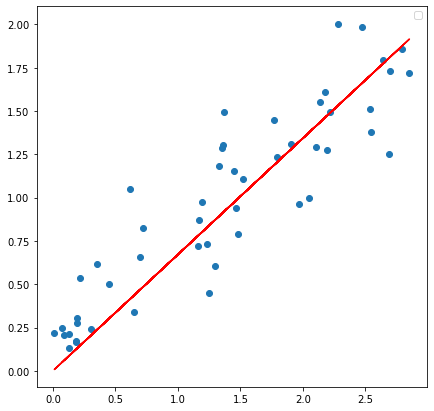

In [137]:
predicts = lr.predict() # 模型的预测值
plt.figure(figsize=(7,7))
plt.scatter(x, y) # 散点图
plt.plot(x, predicts, color = 'red')
plt.legend() # 显示图例，即每条线对应 label 中的内容
plt.show() # 显示图形

In [142]:
labels_disc

,AR1 (Label),AR1 (Infer),AR2 (Label),AR2 (Infer),AR3 (Label),AR3 (Infer),cellType (Label),cellType (Infer),subType (Label),subType (Infer),Cluster_Dim_0,Cluster_Dim_1,KL_Dim_0
0,Ventricle,0,IVS,0,IVS-R,7,SMC,5,Shared-SMC,8,3,3,3
1,Ventricle,0,IVS,3,IVS-M,4,Macro,3,Macro-1,5,2,2,2
2,Ventricle,0,LV,0,LV-mid,4,EC,2,Veinule-EC,11,1,1,1
3,Ventricle,0,IVS,1,IVS-L,0,CM,1,V-CM,0,4,4,4
4,Ventricle,0,RV,2,RV-tra,11,CM,1,V-CM,0,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Ventricle,0,LV,0,LV-mid,7,FB,0,V-FB,1,0,0,0
1996,Ventricle,0,LV,0,LV-epi,11,FB,0,V-FB,1,0,0,0
1997,Ventricle,0,LV,1,LV-mid,1,FB,0,V-FB,1,0,0,0
1998,Atria,1,IAS,3,IAS,2,CM,1,LA-CM,7,4,4,4


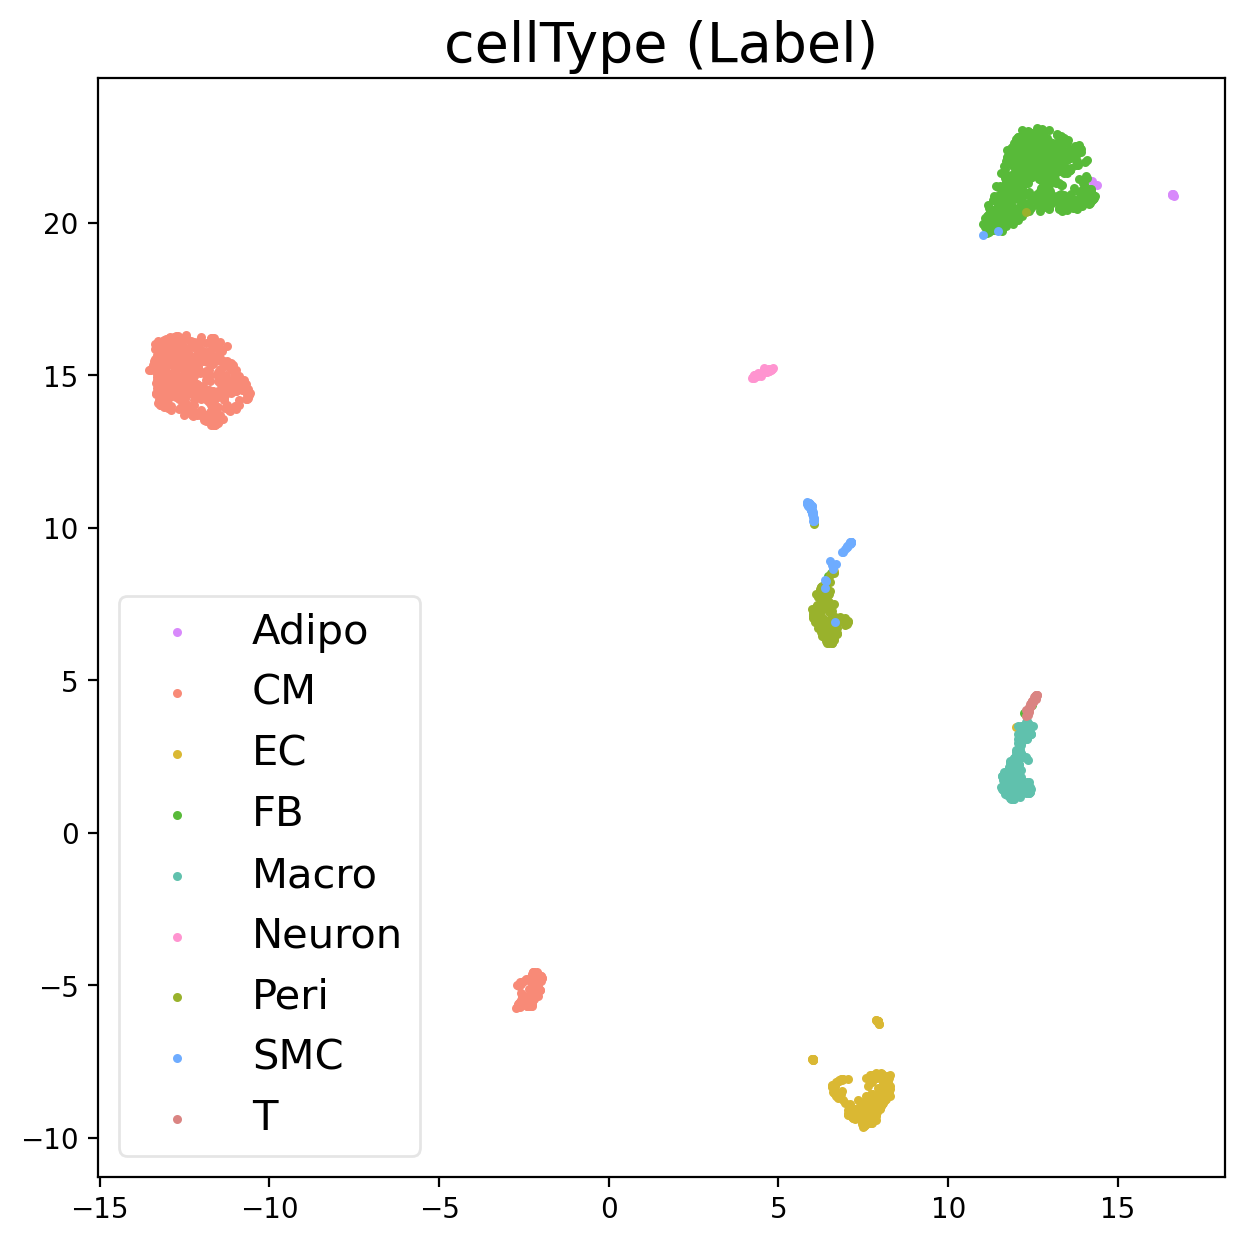

In [150]:
embeddings = u
labels = labels_disc.iloc[:,6]
fig = plt.figure(figsize=(16, 16), dpi= 200)
label = labels
ax = fig.add_subplot(nrow,ncol,idx+1)
for i in np.unique(label):
    index = label == i
    ax.scatter(embeddings[index,0],embeddings[index,1],label=i,c = colors[i],s = 5)
    ax.legend(fancybox=True, framealpha=0.5, prop={'size': 15})
    ax.title.set_text(l)
    ax.title.set_size(fontsize=20)
fig.show()

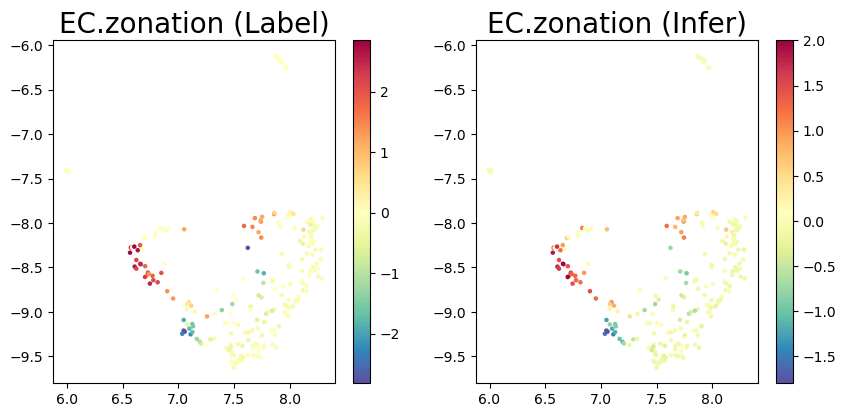

In [119]:
embeddings = u_sub
labels = labels_cont_sub.iloc[:,0:2]
ncol = 2
nrow = len(labels.columns)//2+1
fig = plt.figure(figsize=(10, 5*nrow), dpi= 100)
for idx,l in enumerate(labels.columns):
    label = labels[l]
    ax = fig.add_subplot(nrow,ncol,idx+1)
    sc = ax.scatter(embeddings[:,0],embeddings[:,1], c=label, s = 5, cmap='Spectral_r')
    ax.title.set_text(l)
    ax.title.set_size(fontsize=20)
    fig.colorbar(sc, ax=ax)
fig.show()

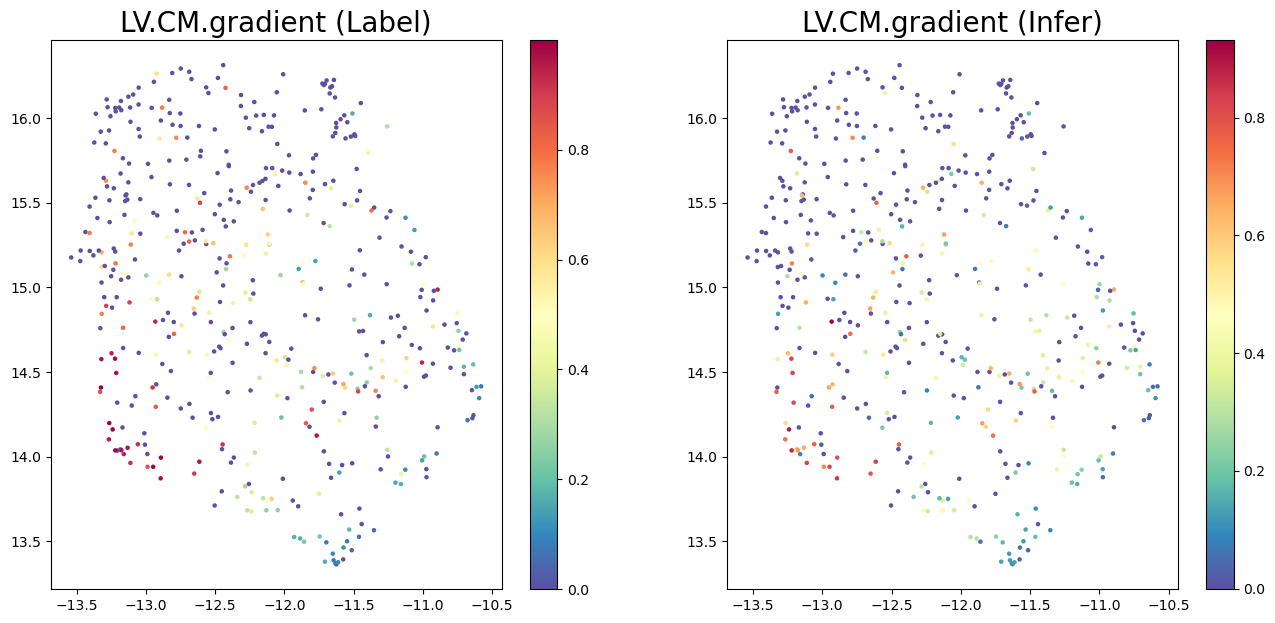

In [108]:
fig = draw_scatter_with_continuous_labels(u_sub, labels_cont_sub.iloc[:,2:4])

fig.show()

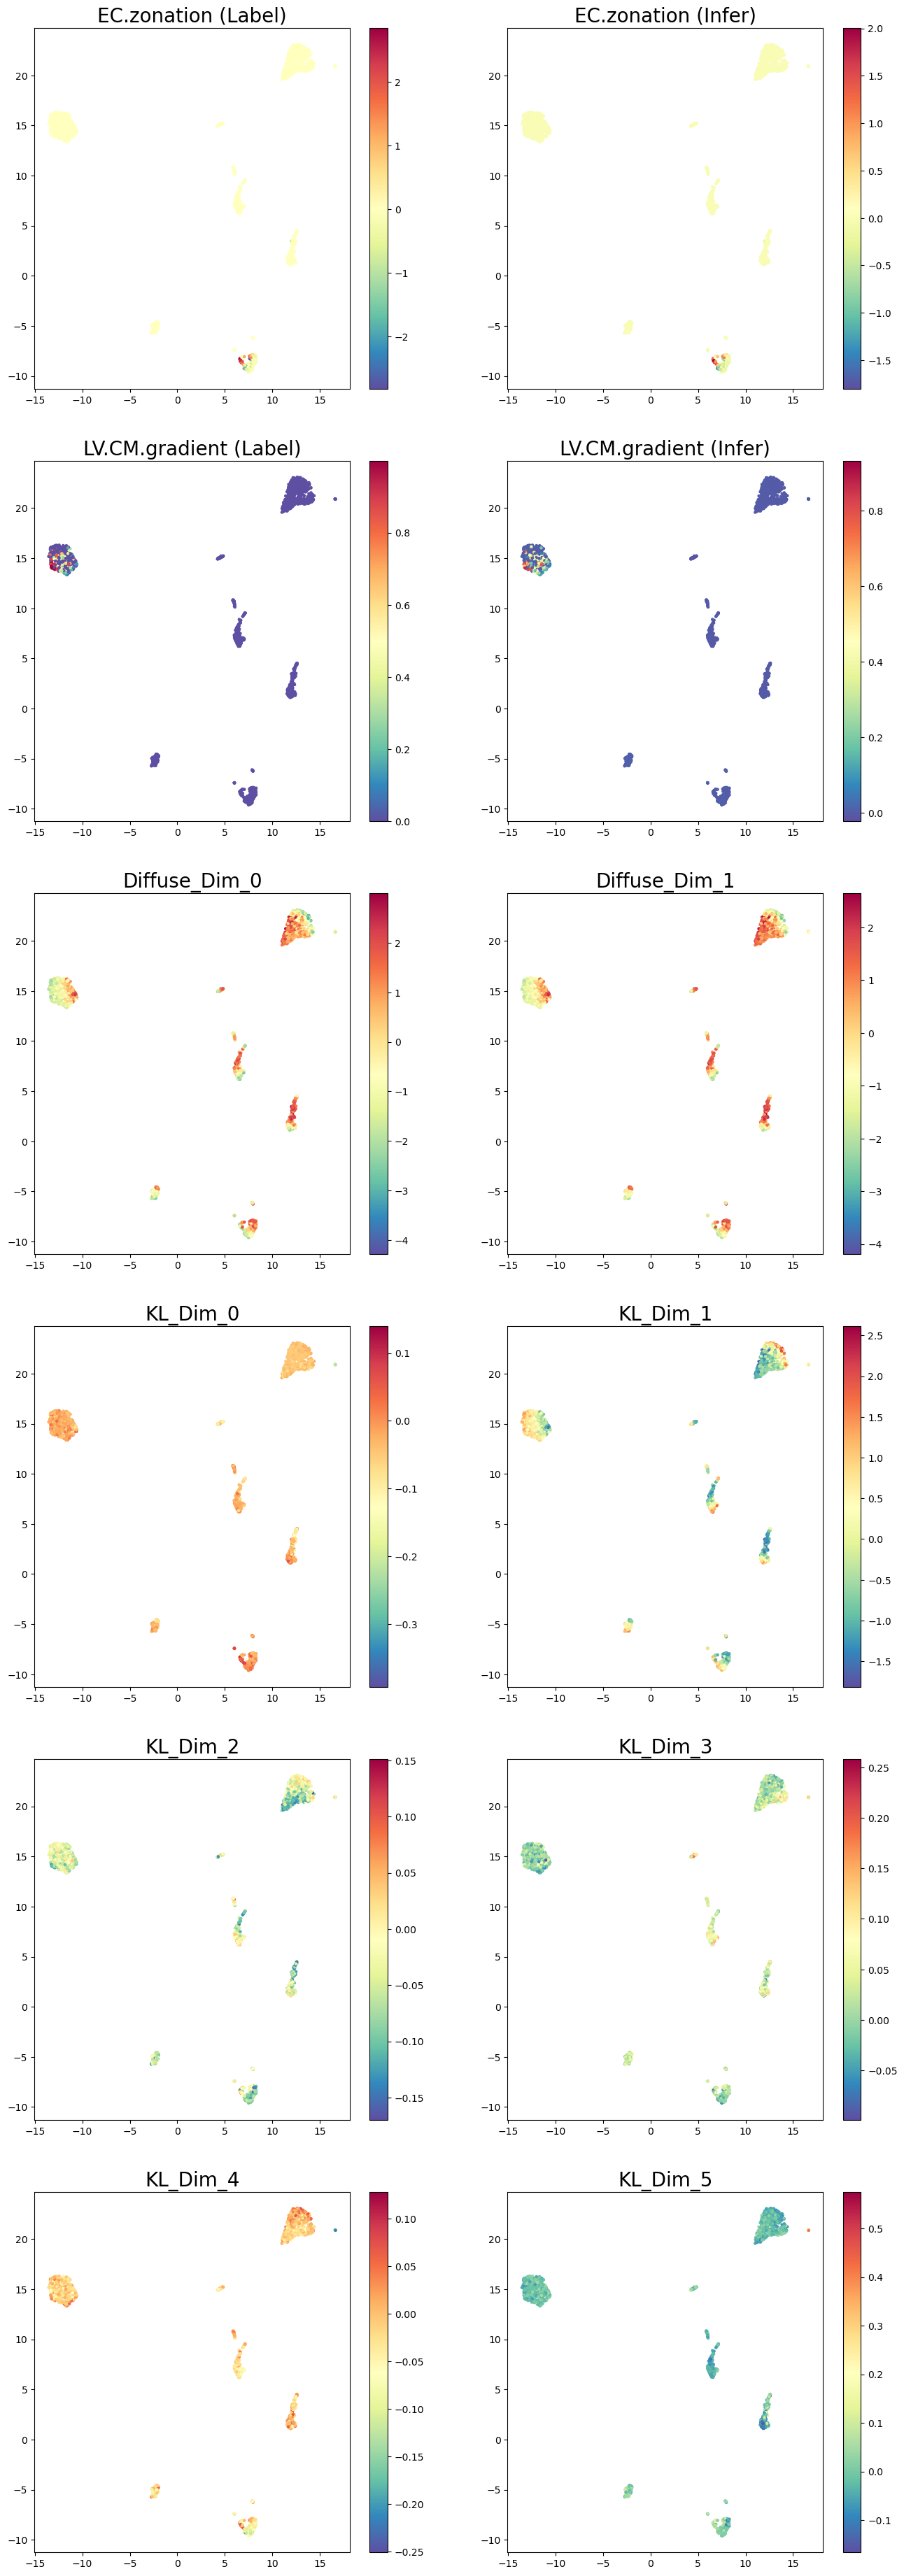

In [106]:
fig = draw_scatter_with_continuous_labels(u, labels_cont)
fig.show()

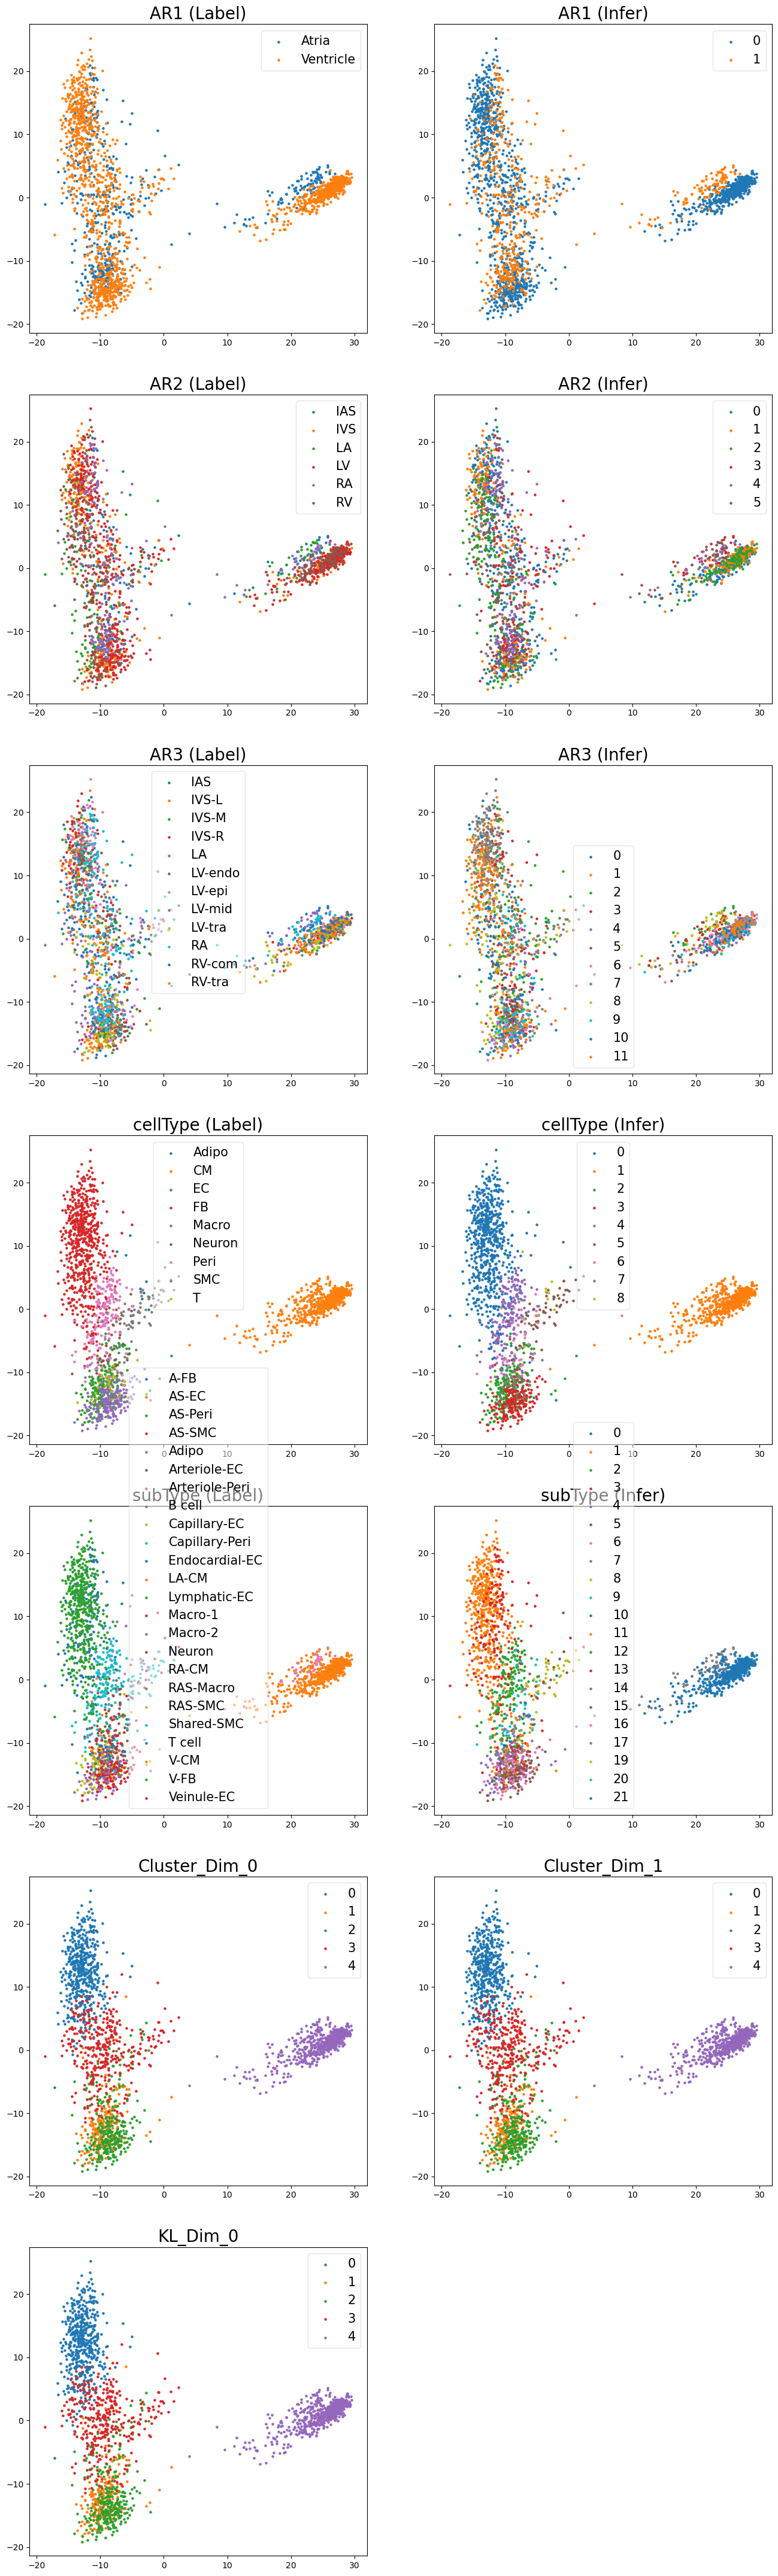

In [15]:
fig = draw_scatter_with_discrete_labels(pcs, labels_disc)
fig.show()

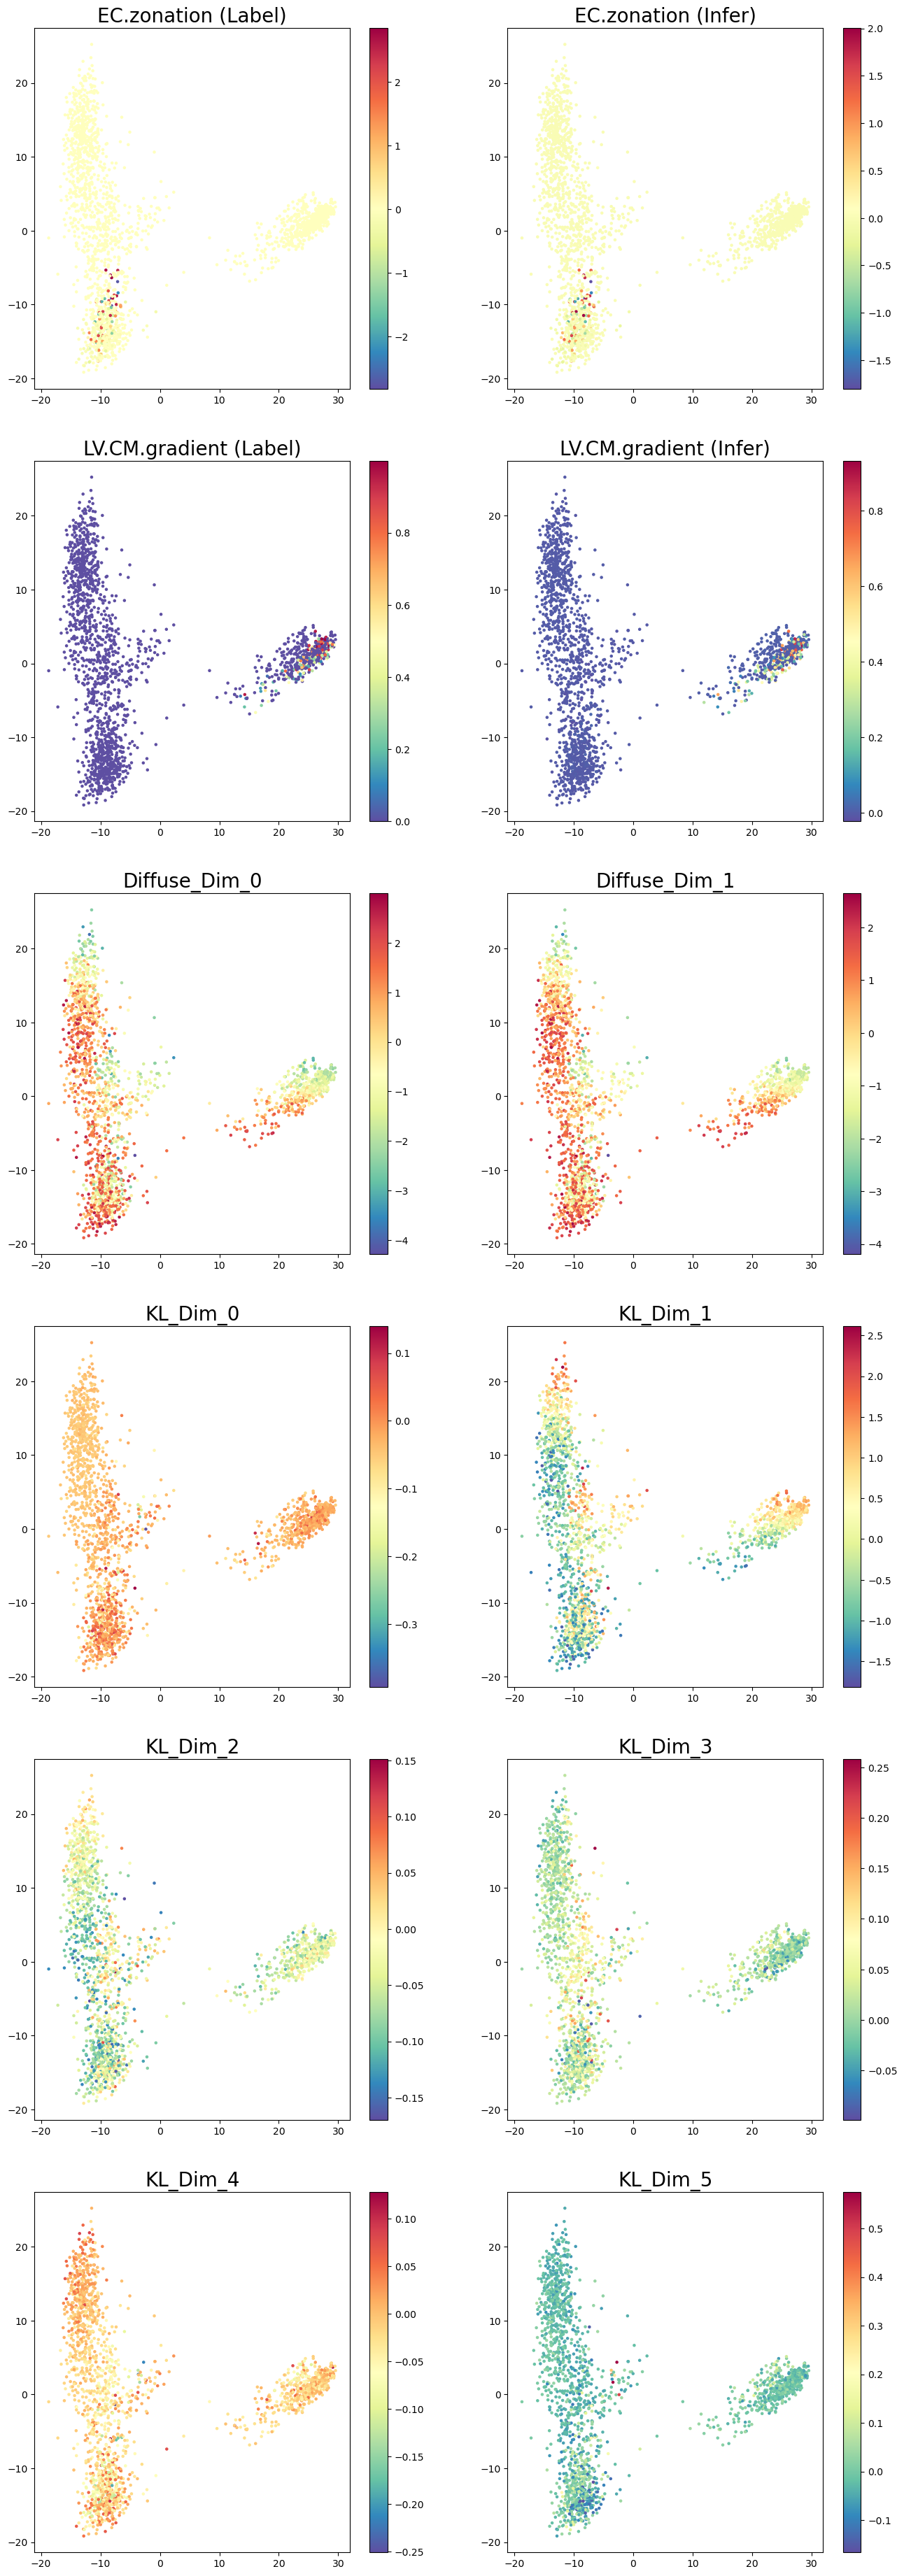

In [16]:
fig = draw_scatter_with_continuous_labels(pcs, labels_cont)
fig.show()

In [17]:
ARI_dict = {}
for ct in np.unique(labels_disc['cellType (Label)']):
    tempLoc = [l==ct for l in labels_disc['cellType (Label)']]
    tempDF = labels_disc.iloc[tempLoc,:]
    ARI_dict[ct] = {}
    for ar in ['AR1','AR2','AR3','subType']:
        tempLabel = tempDF[ar+' (Label)']
        tempInfer = tempDF[ar+' (Infer)']
        tempARI = sklearn.metrics.adjusted_rand_score(tempLabel,tempInfer)
        ARI_dict[ct][ar] = tempARI
pd.DataFrame(ARI_dict)

,Adipo,CM,EC,FB,Macro,Neuron,Peri,SMC,T
AR1,0.000000,0.983653,0.729605,0.850345,0.786418,0.379573,0.758946,0.556273,0.750444
AR2,0.042353,0.592572,0.335239,0.322142,0.305846,0.139724,0.378961,0.186405,0.384339
AR3,0.062833,0.404053,0.184000,0.182390,0.152276,0.113456,0.243951,0.227887,0.159617
subType,0.000000,0.980162,0.694448,0.842193,0.485982,0.000000,0.419239,0.639395,0.156904


In [18]:
set(labels_disc['AR2 (Label)'])

{'IAS', 'IVS', 'LA', 'LV', 'RA', 'RV'}

In [19]:
position_tree = {'AR1': {'Heart':['Atria', 'Ventricle']},
                 'AR2': {'Atria':['IAS','LA','RA'], 'Ventricle':{'IVS','LV','RV'}},
                 'AR3': {'LV': [ 'LV-endo','LV-epi','LV-mid','LV-tra'],
                         'RV': ['RV-com', 'RV-tra'],
                         'IVS':['IVS-L', 'IVS-M', 'IVS-R']}}

In [20]:
ARI_dict = {}
for ct in np.unique(labels_disc['cellType (Label)']):
    if ct == 'Adipo':
        continue
    tempLoc = [l==ct for l in labels_disc['cellType (Label)']]
    tempDF = labels_disc.iloc[tempLoc,:]
    ARI_dict[ct] = {}
    for ar in ['AR1','AR2','AR3']:
        arLabel = tempDF[ar+' (Label)']
        arInfer = tempDF[ar+' (Infer)']
        for pos in position_tree[ar].keys():
            posLabel = [l for l in arLabel if l in position_tree[ar][pos]]
            posInfer = [i for i,l in zip(arInfer, arLabel) if l in position_tree[ar][pos]]
            posARI = sklearn.metrics.adjusted_rand_score(posLabel,posInfer)
            ARI_dict[ct][pos] = posARI
pd.DataFrame(ARI_dict)

,CM,EC,FB,Macro,Neuron,Peri,SMC,T
Heart,0.983653,0.729605,0.850345,0.786418,0.379573,0.758946,0.556273,0.750444
Atria,0.661081,0.370799,0.303224,0.269869,0.164619,0.410170,0.264992,0.290323
Ventricle,0.528017,0.150588,0.210901,0.176161,0.009138,0.232983,-0.056480,0.259414
LV,0.573386,0.064218,0.123024,0.010998,0.019802,0.235659,-0.001155,-0.101695
RV,0.134434,0.001538,0.042925,-0.041441,-0.145455,-0.051889,0.197917,-0.206897
IVS,0.052196,0.000490,0.009135,-0.006735,-0.119403,0.016572,-0.156627,0.000000


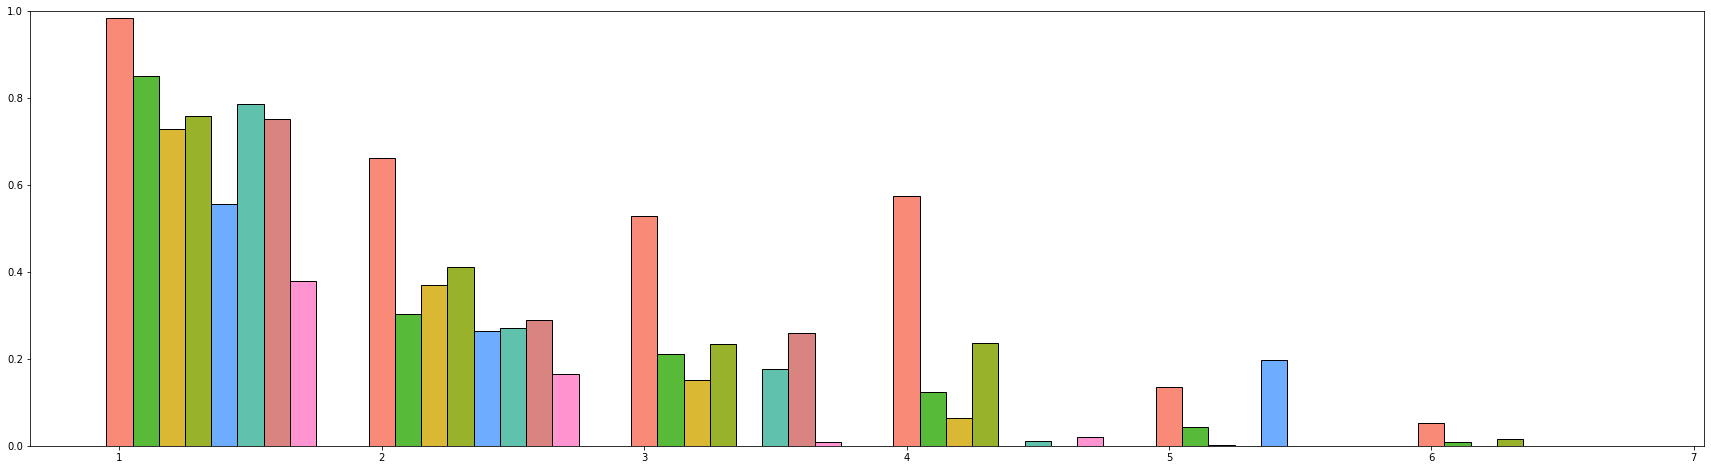

In [21]:
plt.figure(figsize=(30,8))
# '#F88A77','#58BA39','#DAB833','#99B22C','#60C1AD','#6EACFF','#FF94D0','#DB72FB','#DA8482','#D889FB','orange'
# 'CM',     'FB',     'EC',     'Peri',   'Macro',  'SMC',    'Neuron',  'B',     'T',      'Adipo',  'EndoCM'

colors = {'CM': '#F88A77',
          'FB': '#58BA39',
          'EC': '#DAB833',
          'Peri': '#99B22C',
          'SMC': '#6EACFF',
          'Macro': '#60C1AD',
          'T': '#DA8482',
          'Neuron': '#FF94D0',
          'Adipo': '#D889FB'}
df = pd.DataFrame(ARI_dict)
n = 6
X = np.arange(n)+1
for ct in colors.keys():
    Y = df.loc[:,ct]
    plt.bar(X,Y,width = 0.1,facecolor = colors[ct], edgecolor = 'black')
    X = X+0.1
plt.ylim(0,+1.0)
plt.show()

In [23]:
tempLabel = labels_disc['cellType (Label)']
tempInfer = labels_disc['cellType (Infer)']
sklearn.metrics.adjusted_rand_score(tempLabel,tempInfer)

0.977375896521962

# Sankey Plot

In [33]:
cooccur = {}
for i in set(labels_disc['cellType (Label)']):
    cooccur[i] = {}
    for j in set(labels_disc['cellType (Infer)']):
        cooccur[i][j] = sum([_l and _i for _l,_i in zip(labels_disc['cellType (Label)'] == i,
                              labels_disc['cellType (Infer)'] == j)])
pd.DataFrame(cooccur)

,SMC,Macro,FB,Peri,EC,Neuron,Adipo,T,CM
0,2,1,635,5,1,0,1,2,0
1,0,1,0,2,1,0,0,0,593
2,0,0,0,0,232,0,0,0,0
3,0,197,0,0,0,0,0,2,0
4,3,1,0,168,0,0,0,0,0
5,67,0,0,0,0,0,1,0,0
6,0,0,0,0,0,43,0,0,1
7,0,1,0,0,3,0,0,27,0
8,0,0,0,1,0,0,9,0,0


In [39]:
ct_mapping = {}
for i in cooccur.keys():
    ct_mapping[i] = list(cooccur[i].keys())[list(cooccur[i].values()).index(max(cooccur[i].values()))]

In [51]:
label_set = list(colors.keys())
infer_set = [str(ct_mapping[l]) for l in label_set]

In [81]:
tmp = 'F88A77'

In [87]:
def toRgb(tmp):
    tmp = tmp.strip('#')
    opt = re.findall(r'(.{2})',tmp)
    strs = ""
    for i in range (0, len(opt)):
        strs += str(int(opt[i], 16)) + ","
    return('rgba('+strs+'0.4)')

In [89]:
toRgb('#F88A77')

'rgba(248,138,119,0.4)'

In [90]:
data = {'node':{'label': label_set + infer_set, 
                'color': [colors[l] for l in label_set]*2}, 
        'link':{i:[] for i in ['source','target','value','label','color']}}


for idx,i in enumerate(label_set):
    for jdx,j in enumerate(infer_set):
        data['link']['source'].append(idx)
        data['link']['target'].append(jdx + len(label_set))
        data['link']['value'].append(cooccur[i][int(j)])
        data['link']['label'].append('')
        data['link']['color'].append(toRgb(colors[i]))

In [91]:
fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label =  data['node']['label'],
      color =  data['node']['color']
    ),
    # Add links
    link = dict(
      source =  data['link']['source'],
      target =  data['link']['target'],
      value =  data['link']['value'],
      label =  data['link']['label'],
      color =  data['link']['color']
))])

fig.update_layout(title_text="cell type to latent discrete dimension",
                  font_size=10)
fig.show()

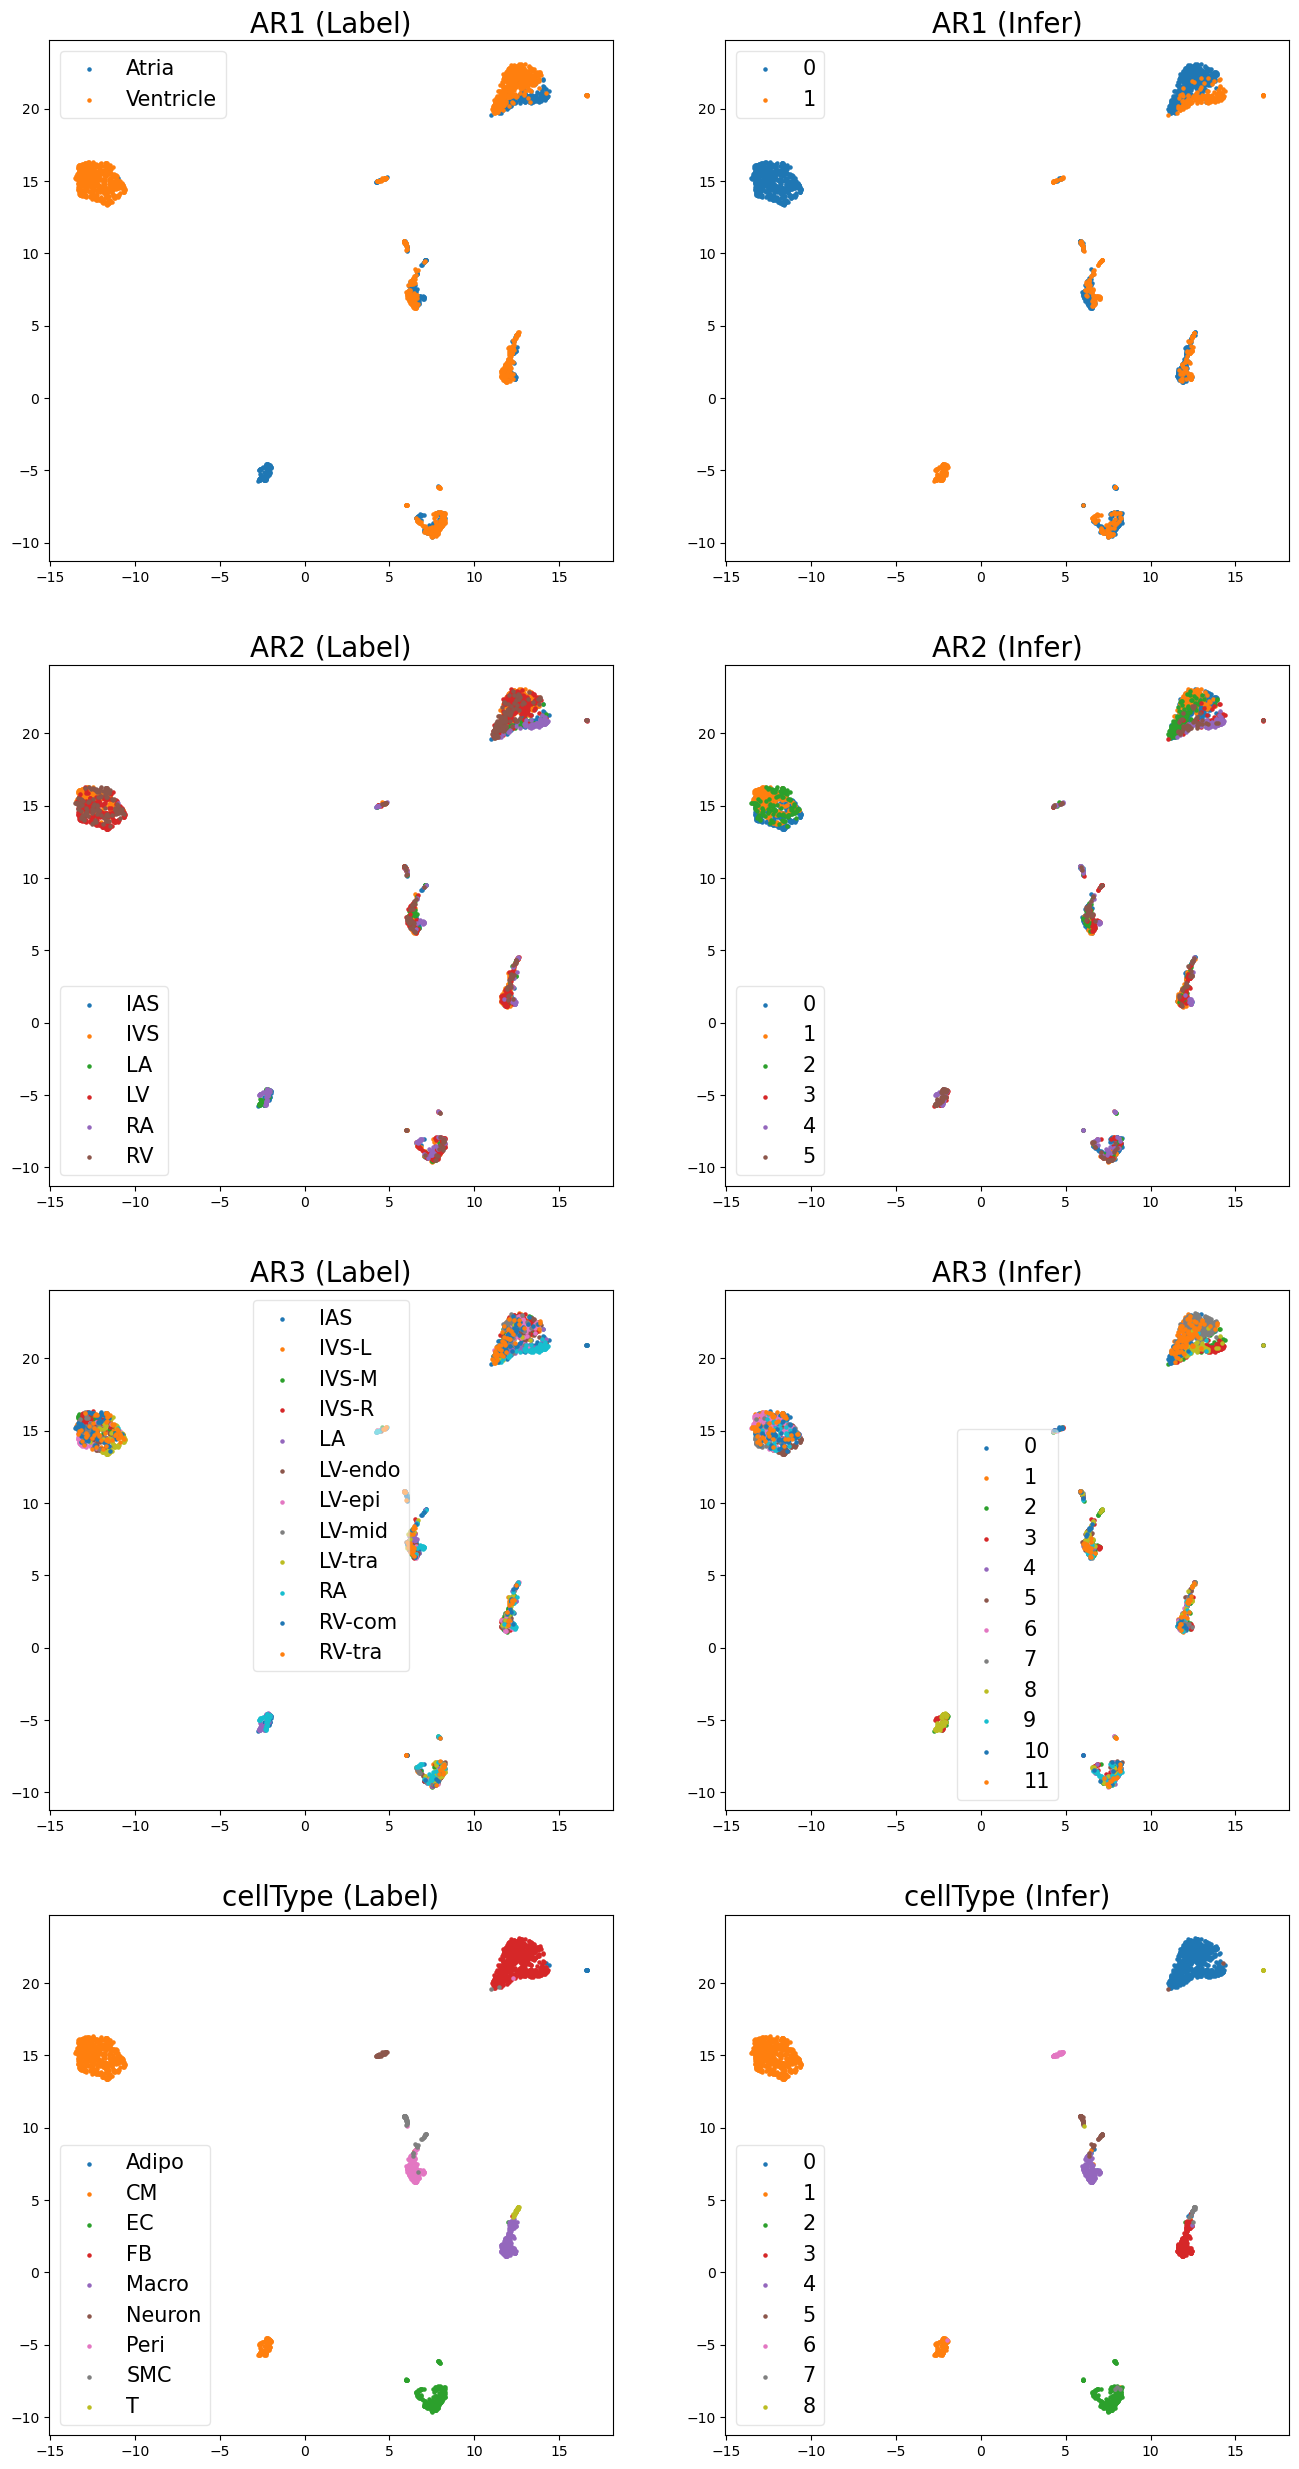

In [115]:
fig = draw_scatter_with_discrete_labels(u, labels_disc.iloc[:,0:8])
fig.show()

In [ ]:
fig = draw_scatter_with_continuous_labels(u, labels_cont)
fig.show()

In [ ]:
max_draw_cont = 8
label_name = 'cellType'
label_pos = [idx for idx,name in enumerate(label_names) if name==label_name][0]
group_index = group_indexes_reverse[label_name]
embeddings = np.array(latent_dist['cont'][0].cpu())
embeddings = embeddings[:,0:min(max_draw_cont, len(embeddings))]
embeddings = pd.DataFrame(embeddings)
embeddings.columns = latent_name_cont[0:min(max_draw_cont, len(embeddings))]
embeddings['label'] = [group_index[int(i)] for i in data[1][:,label_pos].int()]

fig = sns.pairplot(embeddings,hue="label", plot_kws={'size':1}, height = 2, aspect = 1, corner=True)
plt.show()

In [ ]:
latent_u  = umap.UMAP().fit_transform(torch.cat(latent_dist['cont'][0].cpu(), latent_dist['disc'])

In [ ]:
fig = draw_scatter_with_discrete_labels(latent_u, labels_disc)
fig.show()

In [ ]:
fig = draw_scatter_with_continuous_labels(latent_u, labels_cont)
fig.show()